# Configs and Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import (
    VotingClassifier, 
    StackingClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier, 
    HistGradientBoostingClassifier
)
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 5
TARGET = 'Target'
SEED = 27
TUNE_ENSEMBLE_WEIGHTS = True

# Loading and Combining the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

X = train.drop(TARGET, axis=1)
y = train[TARGET]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Training

In [5]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')
        
        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)
            
            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)
            
            oof_preds[val_idx] = y_pred_probs
            
            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)
            
            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')
            
        print(f'\n--- Accuracy: {np.mean(accs):.6f} +/- {np.std(accs):.6f}')
        print(f'--- AUC: {np.mean(aucs):.6f} +/- {np.std(aucs):.6f}\n\n')
        
        return self.model, oof_preds, accs, aucs

In [6]:
xgb_params = {
    'booster':"gbtree",
    'colsample_bylevel':0.5695267422612745,
    'colsample_bynode':0.8390631221126779,
    'colsample_bytree':0.5534666374509267,
    'enable_categorical':True,
    'gamma':0.9069384135972282,
    'max_bin':86,
    'max_delta_step':1.1802158903460869,
    'max_depth':5,
    'max_leaves':64,
    'min_child_weight':8.745168792677534,
    'n_estimators':1539,
    'n_jobs':-1,
    'random_state':27,
    'reg_alpha':9.076826031603096,
    'reg_lambda':3.7191495119106976,
    'subsample':0.9335856723937552,
    'verbosity':0
}

cb_params = {
    'bootstrap_type':"MVS",
    'border_count':200,
    'colsample_bylevel':0.45740812601887504,
    'depth':9,
    'grow_policy':"Depthwise",
    'iterations':1830,
    'l2_leaf_reg':4.349614487163372,
    'min_child_samples':4,
    'random_state':27,
    'random_strength':0.16489500172653238,
    'thread_count':-1,
    'verbose':False
}

lgbm_params = {
    'colsample_bytree':0.35379935570036725,
    'max_depth':77,
    'min_child_samples':199,
    'min_child_weight':0.4410010971781976,
    'n_estimators':169,
    'n_jobs':-1,
    'num_leaves':42,
    'random_state':27,
    'reg_alpha':0.9200214666236493,
    'reg_lambda':0.2652568189927319,
    'subsample':0.9178993412905838,
    'subsample_freq':8,
    'verbose':-1
}

hgb_params = {
    'l2_regularization':0.4495943539321024,
    'max_bins':250,
    'max_depth':4,
    'max_iter':1522,
    'max_leaf_nodes':92,
    'min_samples_leaf':44,
    'random_state':27,
    'verbose':0
}

gb_params = {
    'max_depth':13,
    'max_features':0.8263714279901352,
    'max_leaf_nodes':42,
    'min_samples_leaf':0.10223103929719564,
    'min_samples_split':0.1029614167767282,
    'n_estimators':817,
    'random_state':27,
    'subsample':0.9800346448233184,
    'verbose':0
}

In [7]:
accuracies = {}
aucs = {}
oof_preds = {}
test_preds = {}

In [8]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
test_preds['XGB'] = xgb_model.predict_proba(test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs
oof_preds['XGB'] = xgb_oof_preds

cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_model, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
test_preds['CB'] = cb_model.predict_proba(test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs
oof_preds['CB'] = cb_oof_preds

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
test_preds['LGBM'] = lgbm_model.predict_proba(test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs
oof_preds['LGBM'] = lgbm_oof_preds

hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_model, hgb_oof_preds, hgb_accs, hgb_aucs = Trainer(hgb_model).fit(X, y)
test_preds['HGB'] = hgb_model.predict_proba(test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs
oof_preds['HGB'] = hgb_oof_preds

gb_model = GradientBoostingClassifier(**gb_params)
gb_model, gb_oof_preds, gb_accs, gb_aucs = Trainer(gb_model).fit(X, y)
test_preds['GB'] = gb_model.predict_proba(test)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs
oof_preds['GB'] = gb_oof_preds

Training XGBClassifier
--- Fold 1 - Accuracy: 0.836644, AUC: 0.930521
--- Fold 2 - Accuracy: 0.837101, AUC: 0.932307
--- Fold 3 - Accuracy: 0.835403, AUC: 0.929514
--- Fold 4 - Accuracy: 0.833235, AUC: 0.929363
--- Fold 5 - Accuracy: 0.825590, AUC: 0.924143

--- Accuracy: 0.833595 +/- 0.004221
--- AUC: 0.929170 +/- 0.002724


Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.836448, AUC: 0.930153
--- Fold 2 - Accuracy: 0.837493, AUC: 0.932018
--- Fold 3 - Accuracy: 0.834422, AUC: 0.929325
--- Fold 4 - Accuracy: 0.832843, AUC: 0.929248
--- Fold 5 - Accuracy: 0.826897, AUC: 0.924452

--- Accuracy: 0.833621 +/- 0.003727
--- AUC: 0.929039 +/- 0.002501


Training LGBMClassifier
--- Fold 1 - Accuracy: 0.837036, AUC: 0.930935
--- Fold 2 - Accuracy: 0.836317, AUC: 0.932722
--- Fold 3 - Accuracy: 0.836579, AUC: 0.930180
--- Fold 4 - Accuracy: 0.834804, AUC: 0.930146
--- Fold 5 - Accuracy: 0.826635, AUC: 0.924594

--- Accuracy: 0.834274 +/- 0.003892
--- AUC: 0.929715 +/- 0.002726


Training H

In [9]:
def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)
    gb_weight = trial.suggest_float('gb_weight', 0.0, 1.0)

    weights = [xgb_weight, cb_weight, lgbm_weight, hgb_weight, gb_weight]
    weights /= np.sum(weights)
    
    preds = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_preds.keys(), weights):
        preds += oof_preds[model] * weight
        
    preds = np.argmax(preds, axis=1)
    
    return accuracy_score(y, preds)

if TUNE_ENSEMBLE_WEIGHTS:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000)

    best_weights = study.best_params
    best_weights = [best_weights[f'{model}_weight'] for model in ['xgb', 'cb', 'lgbm', 'hgb', 'gb']]
    best_weights /= np.sum(best_weights)

    print(f'Best weights: {best_weights}')
    print(f'Best accuracy: {study.best_value:.6f}')
else:
    best_weights = []

[I 2024-06-05 10:08:02,258] A new study created in memory with name: no-name-6eaa89b3-b7d3-478a-95e8-68325ea60a7b
[I 2024-06-05 10:08:02,276] Trial 0 finished with value: 0.8329151310802687 and parameters: {'xgb_weight': 0.8472725827971495, 'cb_weight': 0.3439562281151297, 'lgbm_weight': 0.041905101098151154, 'hgb_weight': 0.34513499724750063, 'gb_weight': 0.8402812565978782}. Best is trial 0 with value: 0.8329151310802687.
[I 2024-06-05 10:08:02,290] Trial 1 finished with value: 0.833267989231292 and parameters: {'xgb_weight': 0.06341110677986561, 'cb_weight': 0.8467063124245, 'lgbm_weight': 0.14192956457763828, 'hgb_weight': 0.4126853063953687, 'gb_weight': 0.8397246145045525}. Best is trial 1 with value: 0.833267989231292.
[I 2024-06-05 10:08:02,304] Trial 2 finished with value: 0.8338168796884393 and parameters: {'xgb_weight': 0.03110425576842135, 'cb_weight': 0.07951966319730586, 'lgbm_weight': 0.5654323904833944, 'hgb_weight': 0.972989537246487, 'gb_weight': 0.011527426465198665}

Best weights: [0.12813662 0.4138537  0.37047402 0.079187   0.00834867]
Best accuracy: 0.835294


In [10]:
ensemble_oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
for model, weight in zip(oof_preds.keys(), best_weights):
    ensemble_oof_pred_probs += oof_preds[model] * weight

ensemble_oof_preds = np.argmax(ensemble_oof_pred_probs, axis=1)
ensemble_acc = accuracy_score(y, ensemble_oof_preds)
ensemble_auc = roc_auc_score(y, ensemble_oof_pred_probs, multi_class='ovo')

accuracies['Ensemble'] = [ensemble_acc] * N_FOLDS
aucs['Ensemble'] = [ensemble_auc] * N_FOLDS

In [11]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

# Results

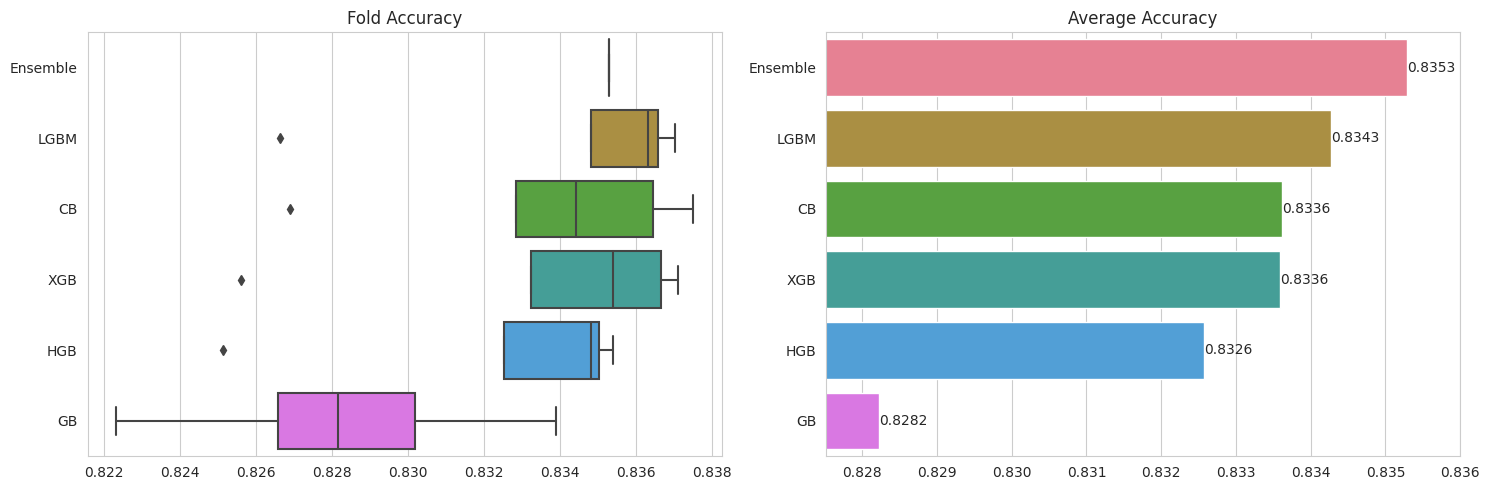

In [12]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

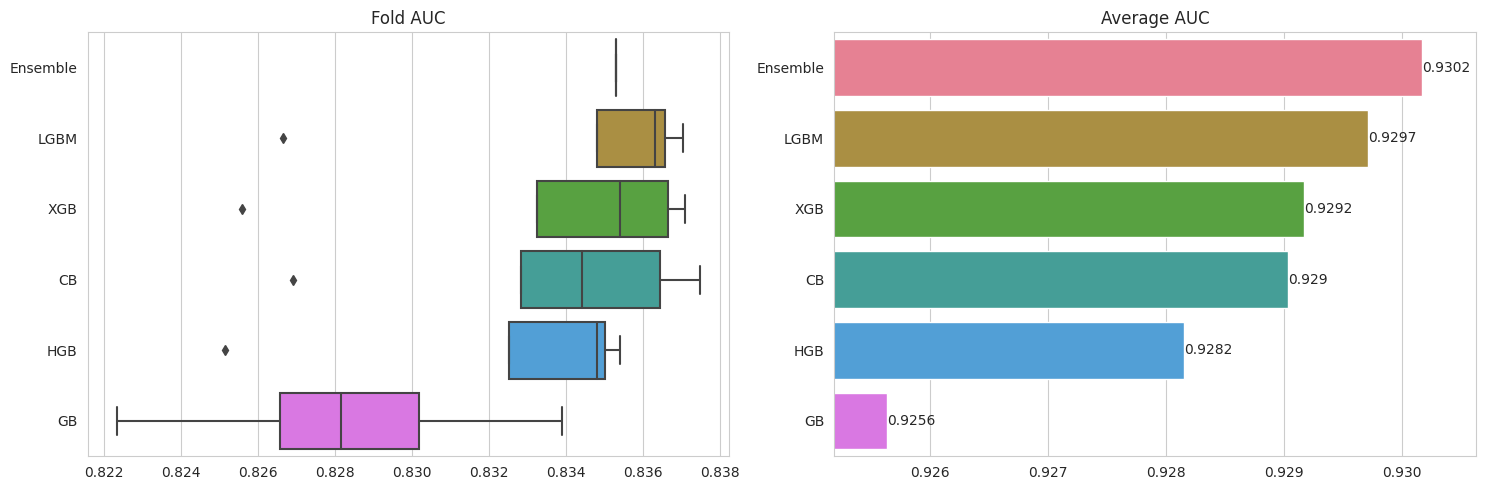

In [13]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

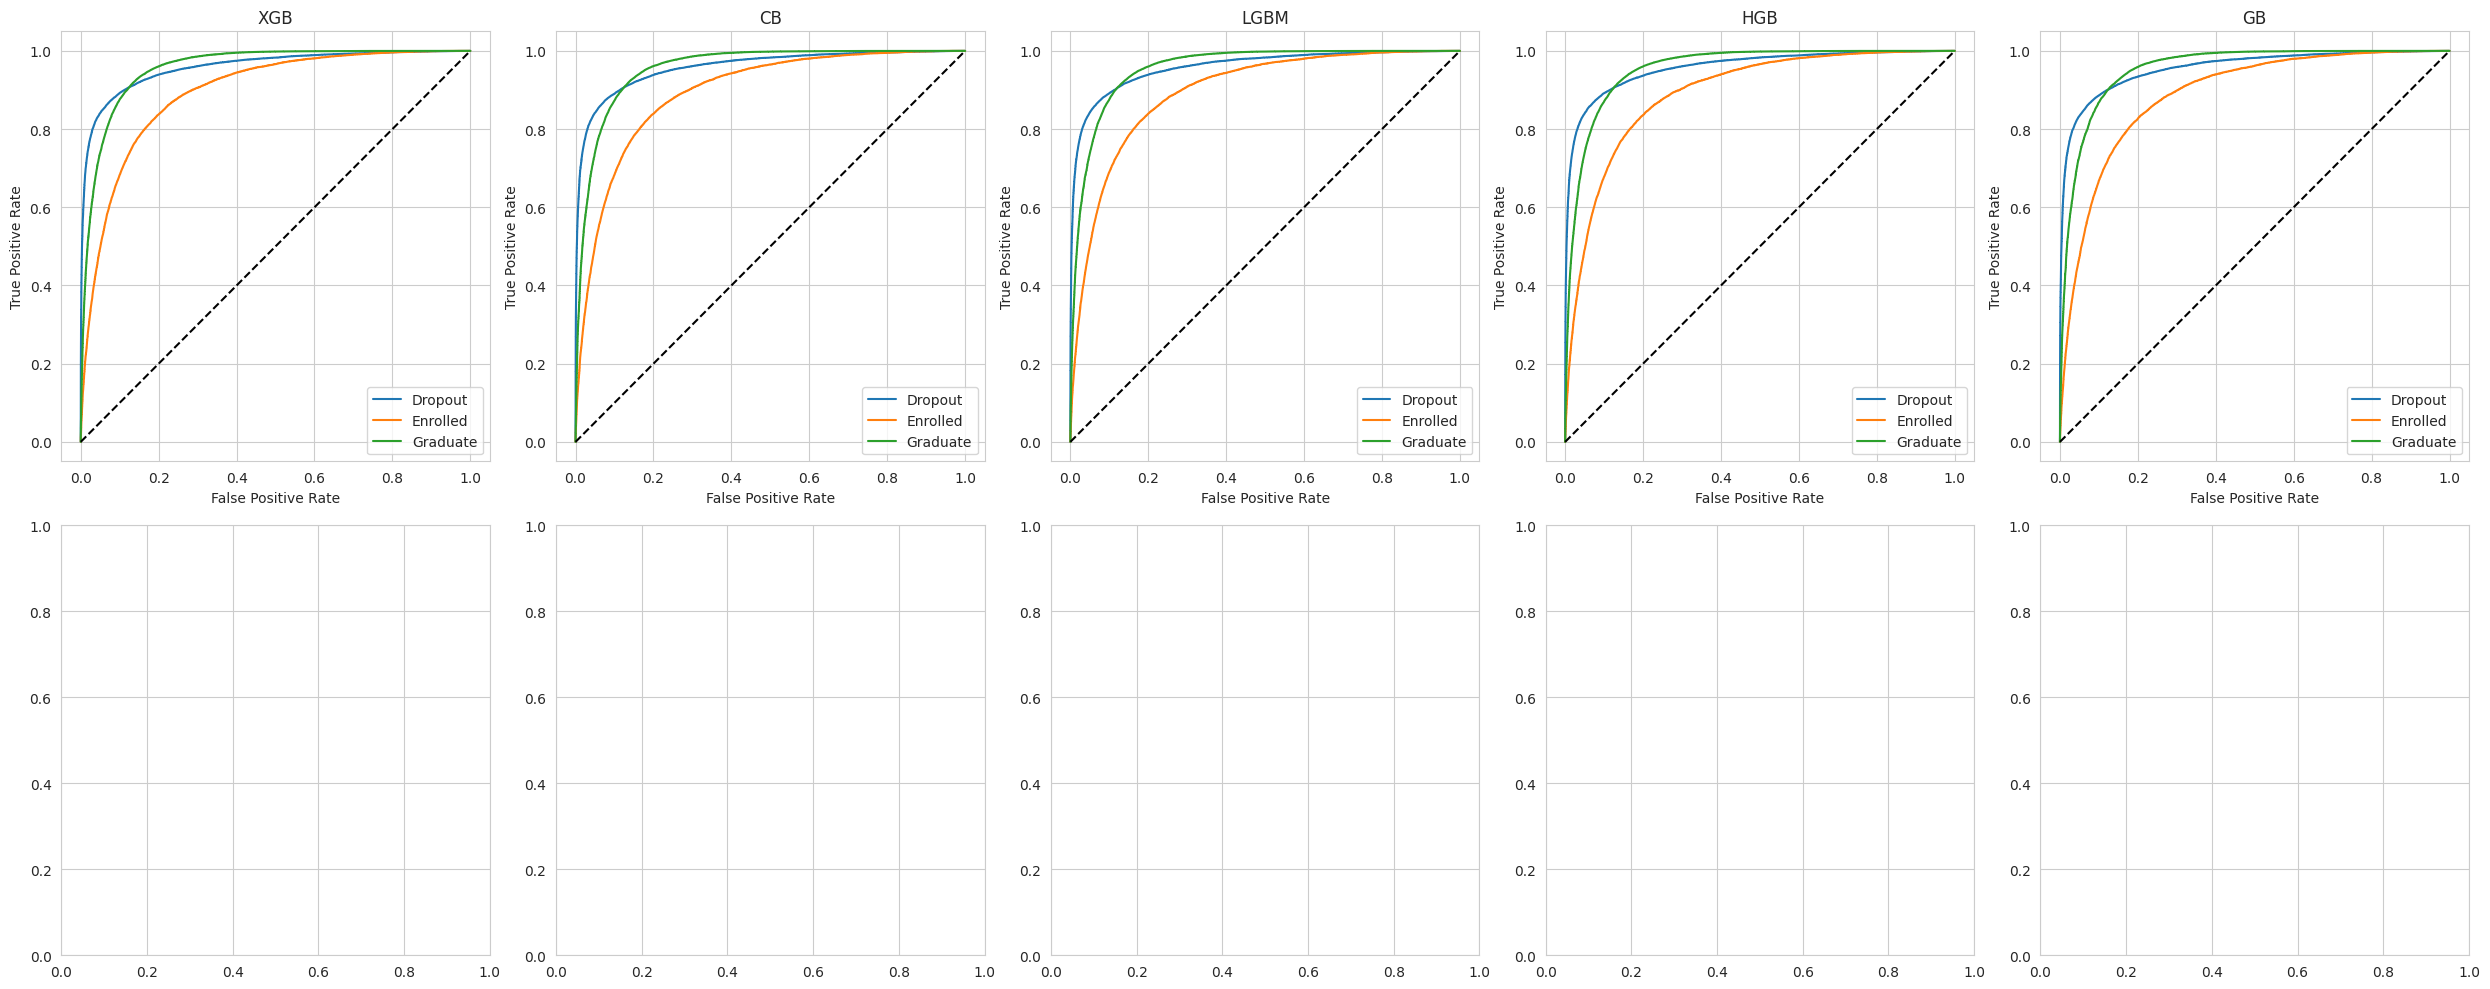

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(y, preds[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')
        
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

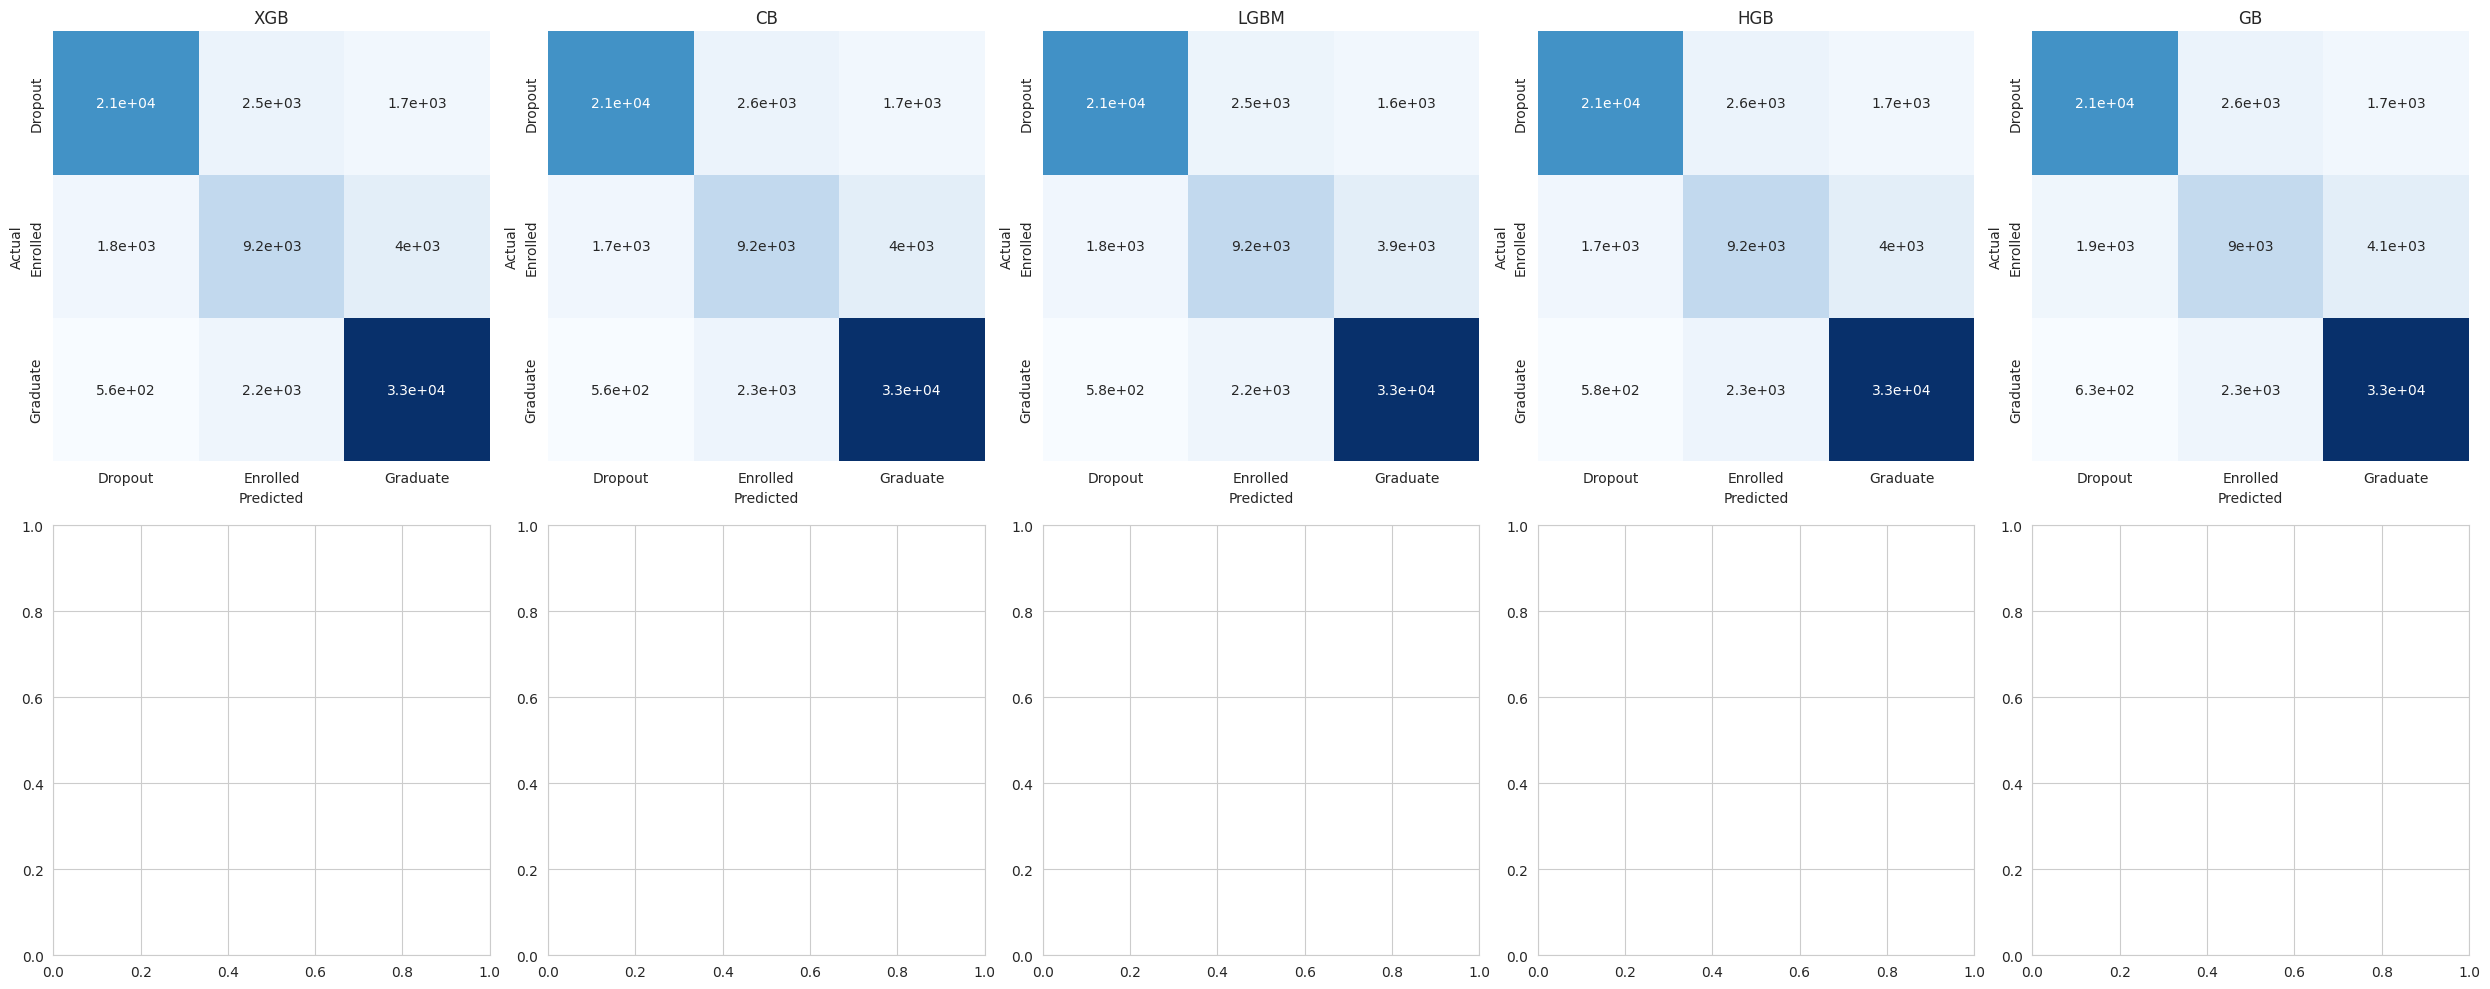

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [16]:
final_preds = np.zeros((test.shape[0], len(np.unique(y))))
for model, weight in zip(test_preds.keys(), best_weights):
    final_preds += test_preds[model] * weight
    
final_preds = np.argmax(final_preds, axis=1)
final_preds = label_encoder.inverse_transform(final_preds)

submission = pd.DataFrame({'id': test.index, 'Target': final_preds})
submission.to_csv(f'ensemble_acc-{np.mean(accuracies["Ensemble"]):.6f}.csv', index=False)